In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from math import pi
import numpy as np
import random
import galois

In [2]:
# right now s != 0
def get_func_details(s, num_q_inp, num_q_out, seed):
    if (num_q_inp > num_q_out):
        print("ERROR: Function can't be two-to one")

    random.seed(seed)
    # shuffle inputs
    inp_list = []
    while len(inp_list) < 2 ** num_q_inp:
        my_val = random.randint(0, 2**num_q_inp)
        if not (my_val in inp_list):
            inp_list.append(my_val)
            if (s != 0):
                inp_list.append(my_val^s)

    out_list = []
    random.seed(seed)
    if (s > 0):
        out_states = np.random.choice(
            range(2**(num_q_out)),  # numbers to sample from
            2**(num_q_inp - 1),  # number of samples
            replace=False,  # makes sure states are only sampled once
        )
    
        for i in out_states:
            out_list.append(int(i))
            out_list.append(int(i))
    else:
        out_states = np.random.choice(
            range(2**(num_q_out)),  # numbers to sample from
            2**(num_q_inp),  # number of samples
            replace=False,  # makes sure states are only sampled once
        )
        for i in out_states:
            out_list.append(int(i))

    return inp_list, out_list

In [3]:
def simon_function(s, num_q_inp, num_q_out, seed):
    inp_list,out_list = get_func_details(s, num_q_inp, num_q_out, seed)
    print("inputs to function:")
    print(inp_list)
    print("outputs to function:")
    print(out_list)

    qc = QuantumCircuit(num_q_inp + num_q_out)

    def flip_bitmask(mask):
        for i in range(num_q_inp):
            if (mask & (2 ** i)) == 0:
                qc.x(i)

    def turn_bit_on(key, turn):
        qc.barrier()
        flip_bitmask(key)
        qc.mcx(list(range(num_q_inp)), turn)
        flip_bitmask(key)

    for (inp, out) in zip(inp_list, out_list):
        qc.barrier()
        for i in range(2 ** num_q_out):
            if (out & (2 ** i)) != 0:
                turn_bit_on(inp, i + num_q_inp)

    return qc

In [4]:
get_func_details(0, 3, 3, 2)

([0, 1, 5, 2, 4, 3, 6, 8], [2, 4, 1, 0, 7, 6, 3, 5])

In [5]:
def compile_circuit(s, num_q_inp, num_q_out, seed):
    qc = QuantumCircuit(QuantumRegister(num_q_inp + num_q_out, "q"), ClassicalRegister(num_q_inp, "a"))
    
    # create first superposistion
    qc.h(range(0, num_q_inp))
    
    qc = qc.compose(simon_function(s, num_q_inp, num_q_out, seed))

    #second superposition
    qc.barrier()
    qc.h(range(0, num_q_inp))

    qc.measure(range(0, num_q_inp), range(0, num_q_inp))
    return qc

inputs to function:
[3, 1, 8, 10, 2, 0, 5, 7]
outputs to function:
[5, 5, 0, 0, 3, 3, 4, 4]


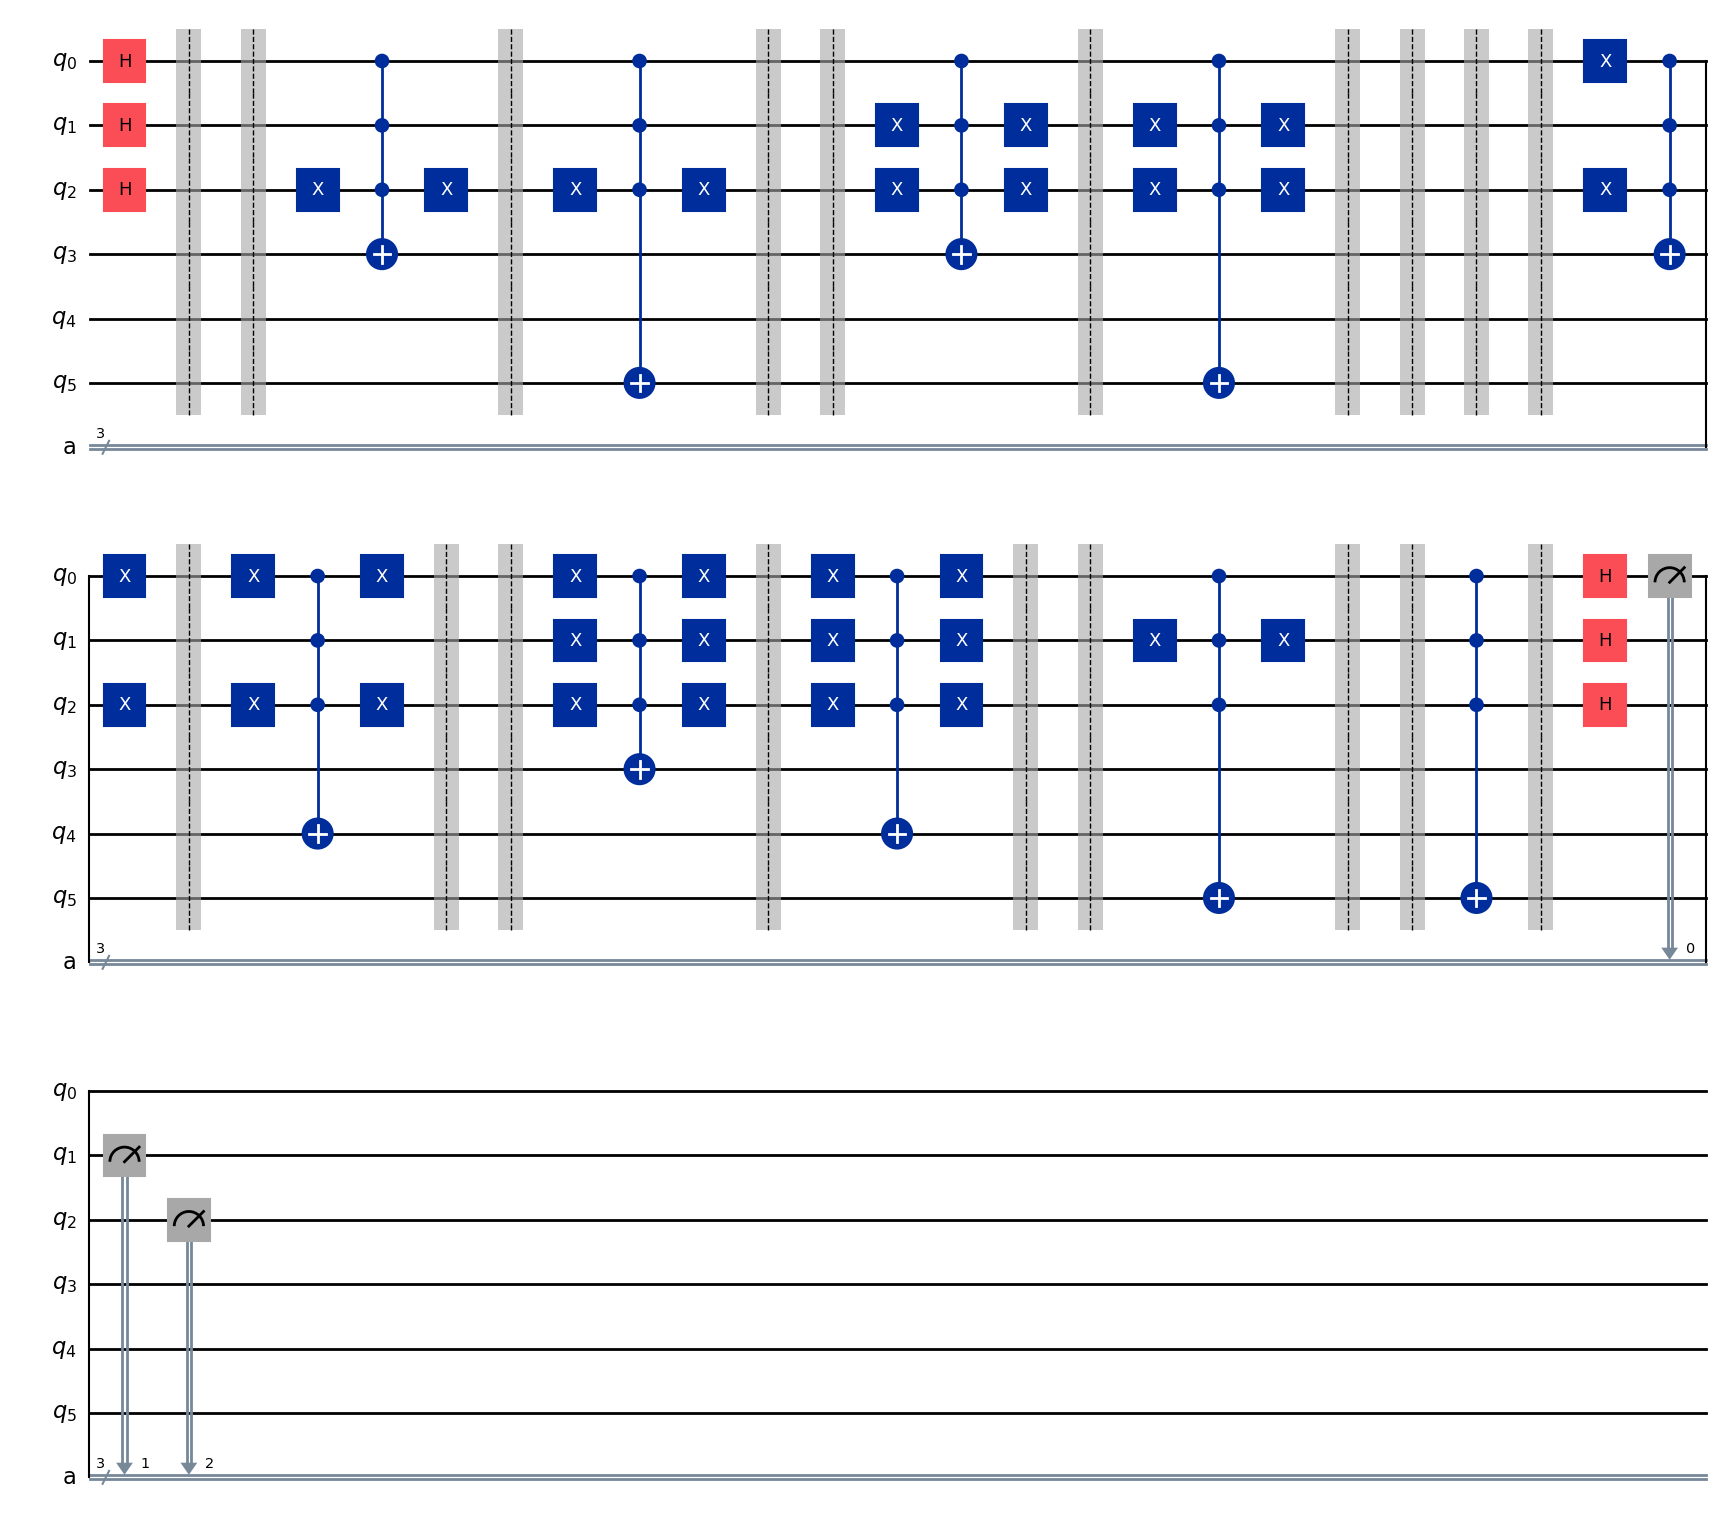

In [6]:
display(compile_circuit(2, 3, 3, 3).draw("mpl"))

In [7]:
def do_run_of_simon(s, num_q_inp, num_q_out, seed):
    result = AerSimulator().run(compile_circuit(s, num_q_inp, num_q_out, seed), shots=100).result()
    statistics = result.get_counts()

    print(statistics)

In [8]:
do_run_of_simon(1, 3, 3, 2)

inputs to function:
[0, 1, 5, 4, 2, 3, 6, 7]
outputs to function:
[3, 3, 6, 6, 4, 4, 0, 0]
{'110': 20, '100': 30, '010': 19, '000': 31}


In [14]:
r = 5
num_q_inp = 7
num_q_out = 13
num_runs = num_q_inp + r
s = 118
seed = 4
GF2 = galois.GF(2)

def get_matrix():
    result = AerSimulator().run(compile_circuit(s, num_q_inp, num_q_out, seed), shots=num_runs).result()
    statistics = result.get_counts()

    mat = []
    for num in statistics.keys():
        curr = []
        for i in num:
            if i == '0':
                curr.append(0)
            else:
                curr.append(1)
        mat.append(curr)
    return mat

In [10]:
def vec_to_int_be(v):
    x = 0
    for bit in v:              # MSB -> LSB
        x = (x << 1) | int(bit)
    return x

def recover_s():
    A = GF2(get_matrix())
    null_space_basis = A.null_space()

    if (len(null_space_basis) == 0):
        return 0
    if (len(null_space_basis) == 1):
        return vec_to_int_be(null_space_basis[0])
    print("INCONCLUSIVE")
    return -1

In [15]:
recover_s()

inputs to function:
[60, 74, 77, 59, 26, 108, 101, 19, 122, 12, 39, 81, 23, 97, 17, 103, 5, 115, 102, 16, 15, 121, 56, 78, 92, 42, 70, 48, 44, 90, 27, 109, 67, 53, 54, 64, 6, 112, 66, 52, 69, 51, 49, 71, 79, 57, 95, 41, 22, 96, 86, 32, 99, 21, 63, 73, 45, 91, 76, 58, 1, 119, 105, 31, 110, 24, 11, 125, 20, 98, 118, 0, 120, 14, 87, 33, 37, 83, 50, 68, 47, 89, 111, 25, 82, 36, 84, 34, 117, 3, 10, 124, 4, 114, 75, 61, 113, 7, 40, 94, 2, 116, 93, 43, 29, 107, 38, 80, 9, 127, 104, 30, 55, 65, 8, 126, 62, 72, 106, 28, 13, 123, 100, 18, 35, 85, 88, 46]
outputs to function:
[3001, 3001, 322, 322, 1441, 1441, 2683, 2683, 6174, 6174, 796, 796, 1523, 1523, 4530, 4530, 1896, 1896, 5515, 5515, 51, 51, 4616, 4616, 271, 271, 5521, 5521, 217, 217, 6298, 6298, 3612, 3612, 7933, 7933, 3113, 3113, 6880, 6880, 3767, 3767, 837, 837, 6779, 6779, 7311, 7311, 5074, 5074, 3508, 3508, 8169, 8169, 5836, 5836, 3107, 3107, 3965, 3965, 7532, 7532, 6493, 6493, 5507, 5507, 6004, 6004, 3185, 3185, 5093, 5093, 1670, 167

118